# epann: Evolving Plastic Artificial Neural Networks


Elan,

Here is a step by step of how to work with some aspects of the package to instantiate CPPN genomes in response to your email. 

Let me know if anything remains unclear.

Chad



1. Introduction
2. Simulating Organisms that Learn
    - Training ANNs via Backpropagation (and variants, i.e. Q-learning)
    - Training ANNs via Neuroevolution
    - Evolving Plastic ANNs
3. Neuroevolution: Genetic Representations of Artificial Neural Networks
    - Direct encodings
    - Indirect Encodings
        - Compositional Pattern Producing Networks (CPPNs)
4. CPPNs as an abstraction of inheritance and development
    - The Substrate
    - Compositional Pattern Producing Networks
    - Sampling connections with respect to the CPPN: ES-HyperNEAT
    - Making CPPN phenotypes plastic: adaptive HyperNEAT
5. The HyperNEAT Algorithm
    - Mutations
        - Functional Mutations
        - Structural Mutations
    - Explicit Fitness Sharing and Speciation
        - Speciation
        - Explicit Fitness Sharing
    - Reproduction
6. Objective Search: Evolving Plastic ANNs with an Explicit Objective
    - The Fitness Landscape
7. Non-Objective Search: Evolving Plastic ANNs without an Explicit Objective
    - Minimal Fitness Criteria
    - Novelty Search
    - Artificial Life with Metabolic Constraints on Connectivity
    - Artificial Life in Environments that are Approximately Sparse




In [301]:
%matplotlib inline

## Definition: 

**Compositional Pattern Producing Networks**

***CPPN***s are an *abstraction of inheritance and development* constructed from simple artificial neural networks. 

Their goal is take in a possible connection in a final agent's brain as coordinates within a defined ***substrate***, and output some feature of that connection, such as it's weight and learning parameters. 

By representing an agent this way, it is not necessary to encode every connection in the final agent phenotype when performing evolutionary computation to find good solutions. 

Instead, we can *indirectly encode* agents with much smaller genotypes that describe the simple CPPN genome. An indirect encoding simplifies our representation of a solution, and allows us to search through a larger portion of the space of possible solutions to solve a task.
    

## Example

Let's start with a simple example using the **epann** package. 

We will construct a population of 5 agents with very simple genome neural networks (CPPNs) to demonstrate how they are initialized, how their structure is related to the final agent brain, and how they change (mutation and reproduction) over the course of evolution. 

In [302]:
from epann.core.population.population import Population

num_agents = 5

pop = Population(num_agents)

for agent in pop.genomes.keys():
    print 'Agent', agent, '-', pop.genomes[agent]


Agent 0 - <epann.core.population.genome.cppn.CPPN instance at 0x7f8237d78e60>
Agent 1 - <epann.core.population.genome.cppn.CPPN instance at 0x7f823dfde998>
Agent 2 - <epann.core.population.genome.cppn.CPPN instance at 0x7f8235839d88>
Agent 3 - <epann.core.population.genome.cppn.CPPN instance at 0x7f823e06f6c8>
Agent 4 - <epann.core.population.genome.cppn.CPPN instance at 0x7f823df51cf8>


As you can see, each agent is defined as an instance of a CPPN object. Within this object are attributes that define its genotype, which can then be used to construct a phenotype for the agent. 

Let's set aside the first agent (**Agent 0**) and take a look at this genome.

In [303]:
current_agent = pop.genomes[0]

Most importantly for our discussion, the current agent has two sets of genome lists that can be modified over the course of evolution among its attributes. 

#### The Node Genome

It has a *node genome*:

In [304]:
print current_agent.nodes

{0: {'activation': 'linear', 'type': 'input'}, 1: {'activation': 'linear', 'type': 'input'}, 2: {'activation': 'linear', 'type': 'input'}, 3: {'activation': 'linear', 'type': 'input'}, 4: {'activation': 'linear', 'type': 'input'}, 5: {'activation': 'ramp', 'type': 'output'}}


It's *node genome* is a dictionary of genes that describe the characteristics of individual nodes in the CPPN.

For example, **Node 5** is an output node ('type') with a unique activation function ('activation'). 

(**Note:** it might seem odd that an output node does not have a more traditional activation function, such as the *sigmoid*. Neurons in CPPNs can have a variety of activation functions that are selected for their ability to introduce repetition or symmetry, which gives rise to the network's *pattern producing* capabilities. More on this distinction later.) 

For now, we can at least observe the possible activation functions output nodes can be assigned to:

In [305]:
from epann.core.tools.utils.activations import Activation
acts = Activation()
print acts.tags

['x_cubed', 'linear', 'sigmoid', 'ramp', 'gauss', 'abs_value', 'tan_h', 'step', 'ReLU', 'sine']


Nodes within the CPPN (except for the input nodes) can have any of these activation functions. For now, let's set the activation function to something simple. This will become clear why when we get to explaining the substrate, and we will change it back when we're done. Once you feel like you have gotten the hang of the relationship between the substrate and the CPPN genome, you can set the output node activation to any of the strings in the above list and see what the substrates look like (then just select Run All from the Cell pull down menu). 

Note: some values are not set up to be sampled with more than one input value (i.e. a meshgrid), so just play around with it a bit to see which ones are working properly. (for example, use 'step', not 'ReLU')


In [370]:
# Save the old randomly generated activation function
old_output_act = current_agent.nodes[5]['activation']

# Re-assign the output node activation function
current_agent.nodes[5]['activation'] = 'ramp'

We start a generation off with 5 agents that have the same number of input and output nodes. As a result, every agent will have identical *node genomes* when they are intialized, save the specific activation functions assigned to the output nodes. 

In [371]:
# Input nodes
print '\nInput nodes are equivalent across the population when initialized...\n'
for agent in range(num_agents):
    print '- Agent', agent
    for node in range(5):
        print '    Node', node, ':', pop.genomes[agent].nodes[node]
        
# Output nodes
print '\nWhile output nodes differ in their specific activation functions...\n'
for agent in range(num_agents):
    print '- Agent', agent
    print '    Node', 5, ':', pop.genomes[agent].nodes[5]


Input nodes are equivalent across the population when initialized...

- Agent 0
    Node 0 : {'activation': 'linear', 'type': 'input'}
    Node 1 : {'activation': 'linear', 'type': 'input'}
    Node 2 : {'activation': 'linear', 'type': 'input'}
    Node 3 : {'activation': 'linear', 'type': 'input'}
    Node 4 : {'activation': 'linear', 'type': 'input'}
- Agent 1
    Node 0 : {'activation': 'linear', 'type': 'input'}
    Node 1 : {'activation': 'linear', 'type': 'input'}
    Node 2 : {'activation': 'linear', 'type': 'input'}
    Node 3 : {'activation': 'linear', 'type': 'input'}
    Node 4 : {'activation': 'linear', 'type': 'input'}
- Agent 2
    Node 0 : {'activation': 'linear', 'type': 'input'}
    Node 1 : {'activation': 'linear', 'type': 'input'}
    Node 2 : {'activation': 'linear', 'type': 'input'}
    Node 3 : {'activation': 'linear', 'type': 'input'}
    Node 4 : {'activation': 'linear', 'type': 'input'}
- Agent 3
    Node 0 : {'activation': 'linear', 'type': 'input'}
    Node 

#### The Connection Genome

The CPPN also has a *connection genome* that keeps track of the connections between these nodes:

In [372]:
print current_agent.connections

{0: {'enable_bit': 1, 'in_node': 5, 'weight': -0.6694964313532505, 'out_node': 0}, 1: {'enable_bit': 1, 'in_node': 5, 'weight': 1.82539028004255, 'out_node': 1}, 2: {'enable_bit': 1, 'in_node': 5, 'weight': 0.8763862342734189, 'out_node': 2}, 3: {'enable_bit': 1, 'in_node': 5, 'weight': 1.2931369895594522, 'out_node': 3}, 4: {'enable_bit': 1, 'in_node': 5, 'weight': 0.802118384963248, 'out_node': 4}}



Just like any neural network you are accustomed to seeing, a CPPN is composed of an input layer (**Nodes 0-4**) and an output layer (with a single output node, **Node 5**). 

Each agent begins with 6 total nodes which are *fully connected*, making 5 initial weights. Although agents in the population are *structurally identical* (they have the same number of initial nodes in their CPPN), the weights of these connections will not be the same for each agent.

Let's compare a single connection across the population - **Connection 0**, between **Node 0** and **Node 5** to show this fact:



In [373]:
print 'Connection weights are randomly initialized across the population for the same connection...\n'
for agent in range(num_agents):
    print '- Agent', agent
    print '    Connection', 0, ':', pop.genomes[agent].connections[0]

Connection weights are randomly initialized across the population for the same connection...

- Agent 0
    Connection 0 : {'enable_bit': 1, 'in_node': 5, 'weight': -0.6694964313532505, 'out_node': 0}
- Agent 1
    Connection 0 : {'enable_bit': 1, 'in_node': 5, 'weight': 0.014733169930874333, 'out_node': 0}
- Agent 2
    Connection 0 : {'enable_bit': 1, 'in_node': 5, 'weight': 1.1183923189249478, 'out_node': 0}
- Agent 3
    Connection 0 : {'enable_bit': 1, 'in_node': 5, 'weight': -0.05951662805764614, 'out_node': 0}
- Agent 4
    Connection 0 : {'enable_bit': 1, 'in_node': 5, 'weight': -1.2581991745370176, 'out_node': 0}


Now, the connection genome is really where the meat of the Hyper-NEAT algorithm lies, so let's focus on it a little more. 

Here is what this CPPN genome looks like graphically:

### Figure 1. Initialized CPPN genome

![Figure 1](epann/figures/init_cppn.png)

Each of the nodes have an identification number specific to its node genome (node IDs are written in white). 

Connections also have identification numbers, which we will refer to as *innovation numbers* (innovation numbers written along connections in black). 

This example CPPN is an agent's *genome*. Since neural networks act as function-approximators, an agent's genome is in effect, also a function. In this case, the genome is a function that maps connections in the agent's final brain to the strength of those connections (the weight). 

I will go into some more detail below describing how this is done, but for now it is important to remember that the genome of an agent is a function represented as an artificial neural network. That genome neural network will be used to construct the agent's brain, which is also a neural network. 

In an attempt to ensure that these two neural networks are not confused, CPPN nodes (the genotype) are drawn in blue. CPPN nodes have identification numbers written in white, and connections between nodes have innovation numbers written in black. Agent neural networks (their "brains"), do not have identification numbers for their nodes or connections (they have coordinates, described below). Furthermore, their nodes are drawn in red or orange.

##### Defining nodes in a connection

Let's look at the first connection (**Connection 0**; innovation number = 0) in this **Agent 0**'s connection genome.

In [374]:
print 0, '-', current_agent.connections[0]

0 - {'enable_bit': 1, 'in_node': 5, 'weight': -0.6694964313532505, 'out_node': 0}


As we can verify in **Figure 1** (innovation # label 0), **Connection 0** describes a connection between **Node 0** and **Node 5**. 

These landing points are intuitively labeled within the gene above: **Connection 0** goes *out* from **Node 0**, so it is labelled the 'out_node' of that connection. **Connection 0** terminates *into* **Node 5**, and is thereby **Connection 0**'s 'in_node'. 

You can go over the connection genome for **Agent 0** to verify that the rest of the connections share this convention.



In [375]:
for connection in current_agent.connections.keys():
    print '(innovation # / connection#) :', connection, '-', current_agent.connections[connection]

(innovation # / connection#) : 0 - {'enable_bit': 1, 'in_node': 5, 'weight': -0.6694964313532505, 'out_node': 0}
(innovation # / connection#) : 1 - {'enable_bit': 1, 'in_node': 5, 'weight': 1.82539028004255, 'out_node': 1}
(innovation # / connection#) : 2 - {'enable_bit': 1, 'in_node': 5, 'weight': 0.8763862342734189, 'out_node': 2}
(innovation # / connection#) : 3 - {'enable_bit': 1, 'in_node': 5, 'weight': 1.2931369895594522, 'out_node': 3}
(innovation # / connection#) : 4 - {'enable_bit': 1, 'in_node': 5, 'weight': 0.802118384963248, 'out_node': 4}


##### CPPN Connection weights

Each connection has a weight labeled by the key 'weight'. This value is randomly generated for each agent and connection in every experiment. 

##### The enable/disable bit

A label which may seem out of place is the 'enable_bit'. In our genetic algorithm (Hyper-NEAT), mutations will cause the topology of this CPPN to change over time. **Connection 0** (which goes from **Node 0** to **Node 5**) could be replaced by other connections that connect it to different nodes. If this occures, then the connection will no longer be expressed. 

It will become clear once we get deeper into the mutations that can happen to a genome how labelling connections with *innovation numbers* becomes useful in experiments, but basically these labels allow us to compare the evolutionary histories of a particular agent during the reproduction stages of our genetic algorithm. 

We can line up innovation numbers between two parents, and have some confidence that they share similar histories of mutations if their innovation numbers are similar. 

Because we would like to be able to compare agents to one another this way, it would not be advantageous to, for example, delete a mutation entirely from a genome. Instead, we can *flip the enable_bit* gene in a genome, that is reassign the 'enable_bit' attribute for a connection to 0. Doing this turns off this connection from being expressed in the genome without deleting it entirely. 

Perhaps this is a lot to cover without seeing a more concrete example, so lets take a moment to break a part the relationship between a CPPN genome and the final agent neural network phenotype that we want to construct and evaluate on a task.

## The Substrate

An important starting point when thinking about our CPPN abstraction is that we are going to treat our final agent neural network, the brain that will actually be interacting with and learning from the task we are interested in, as something that exists in a two-dimensional space. As a consequence, individual nodes in that network can be defined with locations within that space. 

### A simple task

A very simple task that we might be interested in having our agents solve is one modified off the game Flappy Bird. (a single frame from this task is shown below in **Figure 2**)

An agent remains stationary in a column of a grid world, while the world continues to fly by it, updating the values of columns with each time step. The agent in **Figure 2** below is black, nutrients in the world are green, and blue pixels indicate the agent's field of view (what the organism can actually see around it).

While the agent always remains in the same column, it can execute one of three actions at any time based on what it sees in the environment to change its row. It can stay in its current row, or it can move upwards or downwards one row. 

We would like to find agents who can feed themselves - that is, organisms that can observe nutrient locations and execute the appropriate actions to pass through those pixels and ingest them. (One potential objective is to find agent's who eat the most nutrients in a given trial)


If we designed a neural network for this controller, it would require at least six input nodes (one for each of the pixels in its field of view) and three output nodes (one for each of the potential actions). 



### Figure 2. Example Control task


![Figure 1](epann/figures/agent.png)

### The substrate

Now that we have chosen a simple task for our agents, let's return to defining a ***substrate***, which defines nodes in our agent's brain as having locations in a two-dimensional space. Let's take a moment and visualize the nodes we know our agent must contain (6 input nodes and 3 output nodes) in this space:

### Figure 3. Substrate Coordinate Space

![Figure 3](epann/figures/substrate1.png)

Remember, this space and the neural network it contains is different than the Compositional Pattern Producing Network (CPPN) genome shown before. CPPNs do not live in this space - it is a space where we can assign locations to nodes in our agent's "brain". Nodes in this network are drawn in red to further distinguish them from the CPPN (which were drawn in blue). Like any other controller neural network, an observation from the environment is used as these input nodes, and it outputs a selected action.

- From **Figure 3** we can immediately notice a few things:

    1) The substrate coordinate space is continuous between $-1$ and $+1$ in both $x$ and $y$. ( $ x, y \in [-1, 1] $ )

    2) *Input nodes* can be defined with coordinates that describe their *location* along the bottom edge of this space: $(x_i, -1)$. 
    
    3) *Output nodes* can be defined with coordinates that describe their *location* along the top edge of this space: $(x_o, +1)$. 
    
    
If we assume that our input nodes nodes are evenly spaced along the bottom edge, we can initialize their locations as:

In [376]:
import numpy as np

input_locations = [ [x, -1.0] for x in np.linspace(-1, 1, 6) ]
print input_locations

[[-1.0, -1.0], [-0.59999999999999998, -1.0], [-0.19999999999999996, -1.0], [0.20000000000000018, -1.0], [0.60000000000000009, -1.0], [1.0, -1.0]]


Similarly, if our 3 output nodes are evenly spaced along the top edge, then their coordinates are:

In [377]:
output_locations = [ [ x, 1.0 ] for x in np.linspace(-1, 1, 3) ]
print output_locations

[[-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]]


Now, the purpose of our CPPN genome is to allow us to more compactly represent an agent's 'brain' as an indirect encoding. The way we have chosen to implement this mapping from genotype to phenotype involves sampling a possible connection between two nodes in the *agent's brain* and feeding it through the CPPN genome function as input. In return, we receive the weight between those two nodes. 

Placing nodes into this substrate space allows us to represent individual nodes in this connection with coordinates, as described above. So let's try a connection given our current initialized CPPN for **Agent 0**. (See visualization on the substrate in **Figure 4**)




### Figure 4: A sample connection on the substrate between an input and output node

![Figure 4](epann/figures/substrate1_connect0.png)

The first input node is located at $[-1.0, -1.0]$, and we are going to determine the weight between it and the first output node, which is located at $[-1.0, 1.0]$ by feeding this connection into our CPPN genome function. 

If we look again at **Figure 1**, we can see that we replace our inputs to the CPPN:

$$ (x_1, y_1, x_2, y_2) = (-1.0, -1.0, -1.0, 1.0) $$

If we evaluate our initialized CPPN genome for this connection, we receive the weight of this connection as output.


In [402]:
from cppn_overview import InitializedAgent

# Import the initialized agent genome into evaluation space
agent = InitializedAgent(current_agent)

# Define the current connection
connection_start = input_locations[0]
connection_end = output_locations[0]

# Evaluate the connection
print '- From input node', connection_start, 'to output node', connection_end, ':'
print '    * weight = ', agent.evaluate(connection_start, connection_end)



- From input node [-1.0, -1.0] to output node [-1.0, 1.0] :
    * weight =  0.515738621767


We have taken a connection in our agent's neural network phenotype described by the coordinates of its nodes in **Figure 4**, fed those coordinates into the agent's CPPN genotype shown in **Figure 1**, and assigned this connection as having a strength equal its output.


We can sample again across all of our input nodes to evaluate the weights to each output node.

In [379]:
for start in input_locations:
    
    print '\nFrom input node', start
    
    for end in output_locations:
    
        weight = agent.evaluate(start, end)
        print '   - to output node', end, ':'
        print '      * weight = ', weight


From input node [-1.0, -1.0]
   - to output node [-1.0, 1.0] :
      * weight =  0.06297529156
   - to output node [0.0, 1.0] :
      * weight =  0.939361525833
   - to output node [1.0, 1.0] :
      * weight =  1.81574776011

From input node [-0.59999999999999998, -1.0]
   - to output node [-1.0, 1.0] :
      * weight =  0.0
   - to output node [0.0, 1.0] :
      * weight =  0.671562953292
   - to output node [1.0, 1.0] :
      * weight =  1.54794918757

From input node [-0.19999999999999996, -1.0]
   - to output node [-1.0, 1.0] :
      * weight =  0.0
   - to output node [0.0, 1.0] :
      * weight =  0.403764380751
   - to output node [1.0, 1.0] :
      * weight =  1.28015061502

From input node [0.20000000000000018, -1.0]
   - to output node [-1.0, 1.0] :
      * weight =  0.0
   - to output node [0.0, 1.0] :
      * weight =  0.135965808209
   - to output node [1.0, 1.0] :
      * weight =  1.01235204248

From input node [0.60000000000000009, -1.0]
   - to output node [-1.0, 1.0

Each value that is returned describes the weight of the connection from one node to another within the substrate according to the CPPN function genome that is initialized. 

Later on in evolution, mutations will change this function in ways that will influence the strength of these connections and fundamentally change the type of agent brain we inherit. 

It is customary to set some minimum weight threshold $w_t$, such that the absolute value of a weight must be greater than some value. Those weights that are less than the threshold are not expressed in the agent's final phenotype. (for each connection, if $|w| < w_t $, $ w \gets 0 $ )

### Hidden nodes

We have shown that a CPPN genome can map a connection to its weight by defining nodes as having coordinates within a two-dimensional substrate for a Flappy Bird-like feeding task. 

If we only sample these possible connections, we will generate an agent phenotype of a fully-connected artificial neural network with 6 input nodes and 3 output nodes (minus those connections that are not expressed, $|w| < w_t$ ).

It may be the case that for certain tasks a neural network with no hidden nodes is sufficient to solve it, however there are plenty of tasks where layers of hidden nodes could be essential in accomplishing the task toward some objective performance measure.

Since CPPNs represent continuous mappings across the entire substrate, nodes can exist at *any* location within it, not just along the top and bottom edges. 

There are a number of ways we can selectively sample possible hidden node locations in the substrate with respect to a given CPPN, but let's start with a simple sampling scheme that is independent of the genome itself: an evenly spaced 5 x 5 resolution grid across the substrate between input and output nodes. **Figure 5** shows what this substrate sampling looks like.

## Figure 5. 5 x 5 resolution hidden node sampling

![Figure 5](epann/figures/substrate1_5by5.png)

Once again, our minimal architecture (inputs and outputs) is in red. Now, however, we have 25 possible hidden node locations within the substrate. We would like to determine if they would provide useful additional information for our agent genome and should be expressed in our agent phenotype network.

Don't worry if our selection of these 25 hidden node locations seems arbitrary right now, because in many ways it is. The substrate is a continuous two-dimensional space, so we could have just as easily only sampled the origin (0,0) or chosen 1000 possible hidden node locations (100x100 resolution). The only difference between these two decisions of hidden node density is that if there is a lot of variation in the CPPN function (weight values vary over the possible hidden node locations from a single starting node), only sampling the origin will not describe that variation. This possible hidden node density is chosen to illustrate that a more effective hidden node sampling can be found by tying the nodes we evaluate to the function they are evaluating from - the CPPN. But we'll get there.

We can once again describe the coordinate locations of these possible hidden nodes as evenly spaced within the substrate:

In [380]:
resX, resY = 5, 5

x = np.linspace(-1, 1, resX)
y = np.linspace(-1, 1, resY)

xv, yv = np.meshgrid(x, y)

And then sample the strength of the connection (evaluate weight) between the each input node and each hidden node:


From  [-1.0, -1.0]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.08441765  0.52261077]
 [ 0.          0.          0.29279303  0.73098615  1.16917927]
 [ 0.06297529  0.50116841  0.93936153  1.37755464  1.81574776]]

From  [-0.59999999999999998, -1.0]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.2548122 ]
 [ 0.          0.          0.02499446  0.46318758  0.90138069]
 [ 0.          0.23336984  0.67156295  1.10975607  1.54794919]]

From  [-0.19999999999999996, -1.0]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.195389    0.63358212]
 [ 0.          0.       

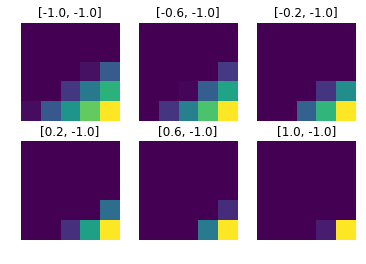

In [381]:
count = 1
for start in input_locations:
    print '\nFrom ', start 
    weights = agent.evaluate(start, [xv, yv])
    print weights
    
    start_label = [ round(value, 2) for value in start]
    
    plt.subplot(2,3,count)
    plt.imshow(weights)
    plt.title(str(start_label))
    plt.axis('off')
    
    count += 1
    
plt.show()

We can similarly test the weight of connections that pass from every hidden node to every output node:


To  [-1.0, 1.0]
[[ 0.06297529  0.          0.          0.          0.        ]
 [ 0.97567043  0.64092222  0.306174    0.          0.        ]
 [ 1.88836557  1.55361736  1.21886914  0.88412092  0.54937271]
 [ 2.80106071  2.4663125   2.13156428  1.79681606  1.46206785]
 [ 3.71375585  3.37900764  3.04425942  2.7095112   2.37476299]]

To  [0.0, 1.0]
[[ 0.93936153  0.60461331  0.26986509  0.          0.        ]
 [ 1.85205667  1.51730845  1.18256023  0.84781202  0.5130638 ]
 [ 2.76475181  2.43000359  2.09525537  1.76050716  1.42575894]
 [ 3.67744695  3.34269873  3.00795051  2.6732023   2.33845408]
 [ 4.59014209  4.25539387  3.92064565  3.58589744  3.25114922]]

To  [1.0, 1.0]
[[ 1.81574776  1.48099954  1.14625133  0.81150311  0.4767549 ]
 [ 2.7284429   2.39369468  2.05894647  1.72419825  1.38945004]
 [ 3.64113804  3.30638982  2.97164161  2.63689339  2.30214518]
 [ 4.55383318  4.21908496  3.88433675  3.54958853  3.21484032]
 [ 5.46652832  5.1317801   4.79703189  4.46228367  4.12753546]]


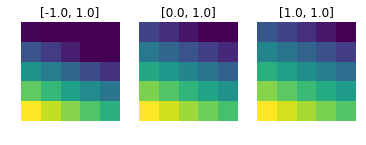

In [382]:
count = 1

for end in output_locations:
    print '\nTo ', end 
    weights = agent.evaluate([xv, yv], end)
    print weights
    
    end_label = [ round(value, 2) for value in end]
    
    plt.subplot(2,3,count)
    plt.imshow(weights)
    plt.title(str(end_label))
    plt.axis('off')
    
    count += 1
    
plt.show()

This process is recursive, and the same set of evaluations need to be executed for connections between every hidden node to every other hidden node in the given 5 x 5 substrate resolution.

### Break - substrate wrt CPPNs

Let's take a moment to set aside the idea that we are arbitrarily designating a resolution by which we are sampling hidden node locations (and therefore possible connections) and look at all possible connection evaluations from each of the input nodes (at a higher resolution of 1000 x 1000 -> 1,000,000 sampled hidden nodes).

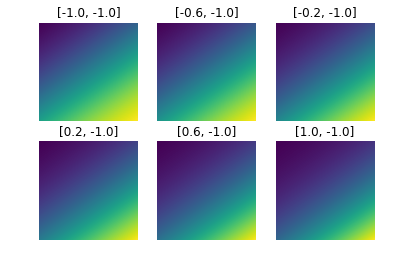

In [403]:

resX, resY = 1000, 1000

x = np.linspace(-1, 1, resX)
y = np.linspace(-1, 1, resY)

xv, yv = np.meshgrid(x, y)

for node in range(len(input_locations)):

    start = input_locations[node]
    weights = agent.evaluate(start, [xv, yv])
    
    start_label = [ round(value, 2) for value in start]

    plt.subplot(2,3, (node+1))
    plt.imshow(weights)
    plt.title(str(start_label))
    plt.axis('off')
    
plt.show()

As well as the substrate evaluation values for all possible connections coming into the ouput nodes.

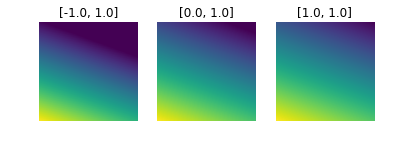

In [384]:
for node in range(len(output_locations)):

    end = output_locations[node]
    weights = agent.evaluate([xv, yv], end)
    
    end_label = [ round(value, 2) for value in end]

    plt.subplot(1,3, (node+1))
    plt.imshow(weights)
    plt.title(str(end_label))
    plt.axis('off')
    
plt.show()

And for the fun of it, let's look at what connections that start at some random hidden node locations look like.

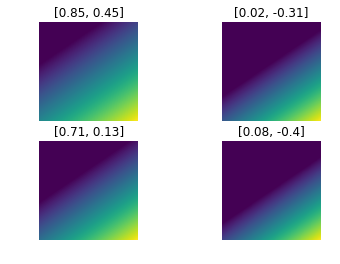

In [385]:
num_random_hiddens = 4

hidden_locations = [ np.random.uniform(-1, 1, size=[1,2]) for location in range(num_random_hiddens)]

for node in range(len(hidden_locations)):

    start = hidden_locations[node][0]
    start = [ start[0], start[1] ]
    
    weights = agent.evaluate(start, [xv, yv])
        
    start_label = [ round(value, 2) for value in start]

    plt.subplot(2,2, (node+1))
    plt.imshow(weights)
    plt.title(str(start_label))
    plt.axis('off')
    
plt.show()


Each agent is initialized with a simple neural network that represents its genome. Hyper-NEAT, the algorithm we will be using to evolve these neural networks, is unique in it's ability to add complexity to neural networks by probabilistically adding nodes and connections, allowing for the possibility for the functions they calculate to become incrementally more complex. It is often the case in other neuroevolution approaches to initialize a population with randomly varying network architectures at the outset, though the justification for doing so is a little unclear. CPPNs in a population here are initialized as neural networks with 5 input nodes and 1 output node (no hidden nodes), that way agents in the initial population only differ in the weights of their connections.